In [1]:
import numpy as np
import matplotlib.pyplot as pl
import itertools
from mpl_toolkits.mplot3d import Axes3D
from RayTraceFun_forDet import *
from PossibleFunctionsDet import *
from BackgroundDet import *
from random import uniform
import random
import matplotlib
#%matplotlib auto

In [2]:
#the functions that incorporate movement of mirror
def OFDM(Rays,y): #output from detector wiht mirror at Y
    Rayf = []
    for i in range(len(Rays)):
        Paths = [TTTTioM,RRRRioM,TTRRioM,RTTRioM,RTRTioM,TRRTioM,RRTTioM,TRTRioM]
        Ri = Rays[i]
        for j in range(8):
            origin = (0,y,0)
            out = Paths[j](Ri,p1,p2,p3,p4,origin)
            if out is not None:
                Rayf.append(out)
    return Rayf

def checkoutraysM(Rays,center,r): #RAYS THAT HIT DETECTOR
    GRays = []
    for i in range(len(Rays)):
        det = PLINTzS(80.,Rays[i][2],Rays[i][3])
        Rays[i][2] = det
        d = ((det[0]-center[0])**2) + ((det[1]-center[1])**2)
        if d <= r**2: 
            GRays.append(Rays[i])
    return GRays

def RunRaysM(n,y): #just give number of rays to be run through this FTS at a specific y!
    sourcepointorigin = [-160.375,-113.,-80.0] #LOCAL 
    sourcethet = [0.,0.,0.] #SHOT STRAIGHT UP
    sourcepoints = specsource(7.9375,sourcepointorigin,sourcethet,n) #LOCAL
    Rays = FSRay(n,sourcepoints, sourcethet,origin10)
    Rayf = OFDM(Rays,y)
    G= checkoutraysM(Rayf,[160.375,-113],7.9375) # GOOD RAYS ONLY 
    Gtestsorted = sortgrid(G)
    Regions = regionalize(Gtestsorted)
    return Gtestsorted,Regions

def SumjRegionsM(n,y): #ALSO INCORPORATES PHASE
    OutRays,regions=RunRaysM(n,y)
    Regions = list(regions)
    jx,jy = gridlines(7.9375,[160.375,-113],200)
    LamdAll = np.linspace(1, 10,300) #possible wavelengths (30-300 Ghz), steps of 1Ghz
    DetTot = []
    for j in range(len(regions)):
        for i in range(len(Regions[j])): #All rays in region j
            ExTot = []
            EyTot = []
            if i != 0 and i != 1:
                JRegion = Regions[j]
                m,p = JRegion[0],JRegion[1] # jx and jy defining the jth region
                Raym = OutRays[JRegion[i]] #ith ray in the jth region
                w = 1
                if m == 17 or p == 17: #end of detector
                    w = 0
                else:
                    w = gaussian3d(Raym[2][0],Raym[2][1],.3,(jx[m]+jx[m+1])/2,(jy[p]+jy[p+1])/2)
                Ex1 = w*(np.cos(Raym[0])*Raym[1]) #split into x and y components of E field
                Ey1 = w*(np.sin(Raym[0])*Raym[1]) #is there abs or not?
                #incorporating phase 
                for q in range(300):
                    Lamd=LamdAll[q]
                    Ex = Ex1*np.cos((Raym[4]%Lamd)*2*np.pi/Lamd)
                    Ey = Ey1*np.cos((Raym[4]%Lamd)*2*np.pi/Lamd)
                    ExTot.append(Ex)
                    EyTot.append(Ey)
        Ij = (np.sum(ExTot))**2 + (np.sum(EyTot))**2
        DetTot.append(Ij)
    return np.sum(DetTot)
def RunFTS(n,div):
    Power = []
    Delay = []
    for y in np.linspace(-25,25,div):
        I = SumjRegionsM(n,y)
        Power.append(I)
        Delay.append(y)
    return Power,Delay   

def test():
    OutRays,regions=RunRaysM(1000,0)
    Regions = list(regions)
    points = [] #testing gaussian
    Rays = []
    jx,jy = gridlines(7.9375,[160.375,-113],200)
    for j in range(len(regions)):
        for i in range(len(Regions[j])): #All rays in region j
            ExTot = []
            EyTot = []
            if i != 0 and i != 1:
                JRegion = Regions[j] #all rays in region j
                m,p = JRegion[0],JRegion[1] # jx and jy defining the jth region
                Raym = OutRays[JRegion[i]] #ith ray in the jth region
                if m == 17 or p == 17:
                    w = 0 #the edges of the detector ? 
                else:
                    w = gaussian3d(Raym[2][0],Raym[2][1],.3,(jx[m]+jx[m+1])/2,(jy[p]+jy[p+1])/2)
                A = [Raym[2][0],Raym[2][1],w]
                points.append(A)
                Rays.append(Raym)
    return points

pl3dsurf = pl.figure().gca(projection = '3d')
for x in  np.linspace(jx[5],jx[6],10):
    for y in np.linspace(jy[5],jy[6],10):
        z = gaussian3d(x,y,.3,(jx[5]+jx[6])/2,(jy[5]+jy[6])/2)
        A = gaussian3d(x+.1,y+1,.3,(jx[5]+jx[6])/2,(jy[5]+jy[6])/2)#boundaries
        pl3dsurf.scatter(x,y,z)
pl.show()
#clearly not normalized? 
#yay now is normalized
#so make edge of the whatsit 


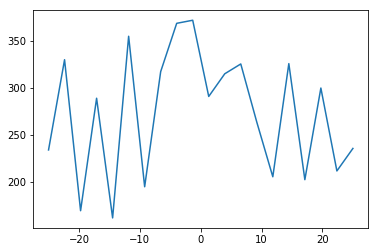

In [5]:
P,D = RunFTS(1000,20)
pl.plot(D,P)
pl.savefig('Plots/'+time.strftime("%Y_%m_%d_%s"))
pl.show()

In [ ]:
#just to test, setting mirror RIDICULOUSLY far away so shouldn't ever hit
for y in np.linspace(-500,-400,10):
    I = SumjRegionsM(n,y)
#ok so i do get a nonetype....

In [ ]:
#test modulation again (using ALL THE PATHS)
def CheckModulate(n,y):
    OutRays,regions=RunRaysM(n,y)
    return len(OutRays)/n
def CheckModulateFTS(n,div):
    Power = []
    Delay = []
    for y in np.linspace(-25,25,div):
        I = CheckModulate(n,y)
        Power.append(I)
        Delay.append(y)
    return Power,Delay   

In [ ]:
P,D = CheckModulateFTS(100,100)
pl.plot(D,P)
pl.show()